# Pitch Classification

### Name: Alex Xu

In [2]:
#Imports
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib.pyplot import figure
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
from scipy import stats
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import sqlite3
import datetime
import seaborn as sns
import math
import statsmodels.api as sm 
import xgboost as xgb

## Problem Statement:

Create a model that can predict the most likely pitch type from the test dataset.

## Data

In [74]:
train = pd.read_csv('Quantitative Analysis Associate Questionnaire/pitchclassificationtrain.csv')
test = pd.read_csv('Quantitative Analysis Associate Questionnaire/pitchclassificationtest.csv')

In [4]:
train.head(10)

,pitchid,pitcherid,yearid,height,initspeed,breakx,breakz,initposx,initposz,extension,spinrate,type
0,1,5,1,72,83.774424,-1.293106,4.451670,-1.330641,6.065956,6.317961,1386.459243,3
1,2,5,1,72,89.642714,-6.550556,7.993455,-1.556463,5.719125,6.119526,1963.264977,9
2,3,4,1,72,91.750648,-6.985574,8.991264,-2.055134,5.780312,6.201200,2360.758263,9
3,4,5,1,72,83.189766,-2.549204,4.844714,-1.001020,6.240138,6.074156,858.997788,7
4,5,2,1,80,92.698738,-5.216516,7.267769,-2.097643,5.776138,6.212281,2060.155099,9
5,6,2,1,80,93.465101,-3.705180,9.575830,-2.412097,5.930423,6.362127,2150.557826,10
6,7,5,1,72,90.133351,-3.457456,9.394351,-1.712198,5.878997,6.315298,2070.610056,10
7,8,2,1,80,94.988449,-0.475622,9.409168,-1.708333,6.168799,6.565337,2254.638912,10
8,9,5,1,72,90.934010,-1.173693,7.685287,-1.005594,5.963014,5.986846,1740.423250,10
9,10,4,1,72,87.374464,1.512633,4.563257,-2.331637,5.982525,6.225165,2442.328132,8


In [5]:
train.columns

Index(['pitchid', 'pitcherid', 'yearid', 'height', 'initspeed', 'breakx',
       'breakz', 'initposx', 'initposz', 'extension', 'spinrate', 'type'],
      dtype='object')

In [75]:
test.columns

Index(['pitchid', 'pitcherid', 'yearid', 'height', 'initspeed', 'breakx',
       'breakz', 'initposx', 'initposz', 'extension', 'spinrate'],
      dtype='object')

In [6]:
train.isnull().values.any()

False

In [7]:
train = train.astype({'pitcherid':'category','yearid':'category','type': 'category'})

Turning `pitcherid` and `yearid` into categorical variables, as well as the pitch `type`

## EDA

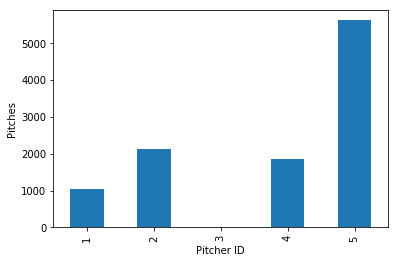

In [8]:
pitchers = train.groupby('pitcherid').size()
pitchers.plot.bar()
plt.xlabel('Pitcher ID')
plt.ylabel('Pitches')
plt.show()

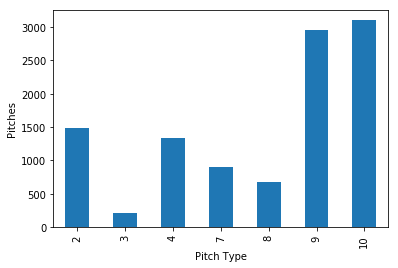

In [9]:
pitch_type = train.groupby(['type']).size()
pitch_type.plot.bar()
plt.xlabel('Pitch Type')
plt.ylabel('Pitches')
plt.show()

## Feature Selection

In [10]:
pitch_data = pd.DataFrame(train,columns=['pitcherid','yearid', 'height', 'initspeed', 'breakx','breakz', 'initposx', 'initposz', 'extension', 'spinrate'])
dummy_pitch_data = pd.get_dummies(pitch_data)

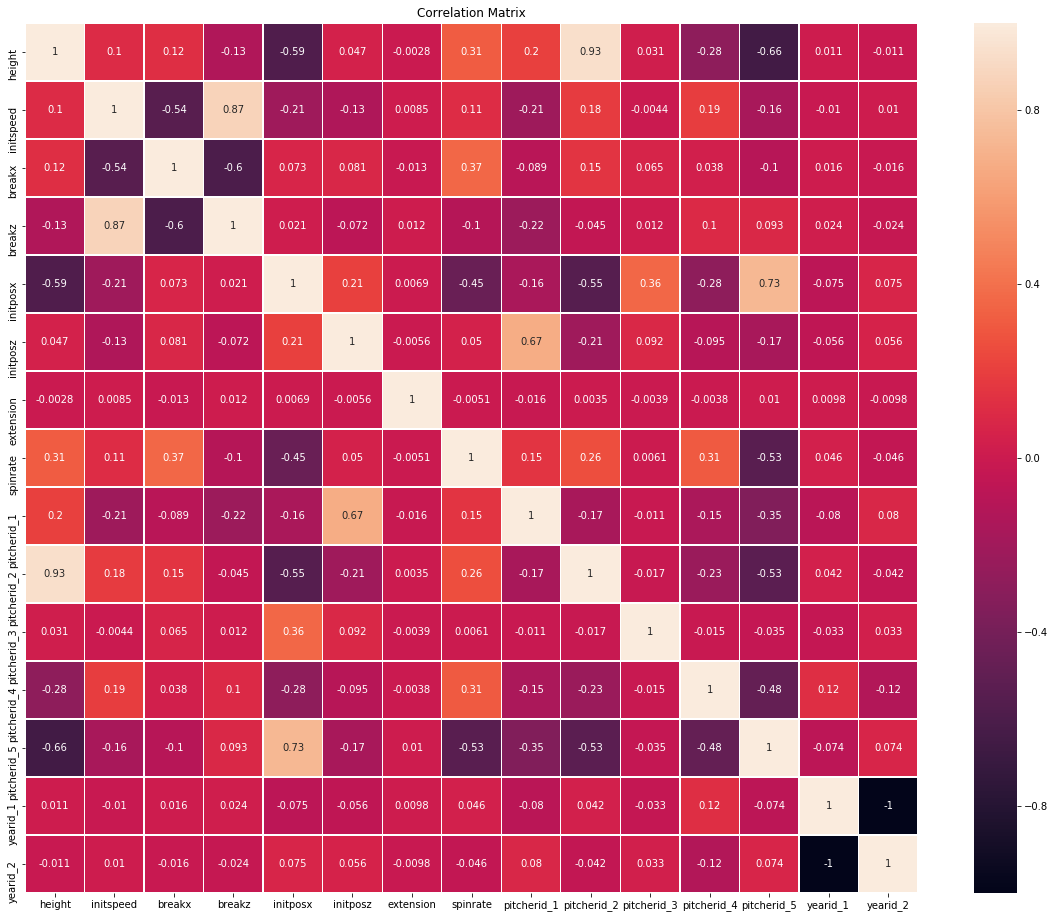

In [13]:
corrMatrix = dummy_pitch_data.corr()
fig, ax = plt.subplots(figsize = (20, 16))

sns.heatmap(corrMatrix, annot = True, linewidths = 0.4, vmax = 1, vmin = -1)
plt.title('Correlation Matrix')
plt.show()

### Feature Selection Functions

In [14]:
def get_features_rfe(model):
    scores = []
    means = []
    for i in range(2,11):
        rfe = RFE(estimator=model, n_features_to_select=i)
        pipeline = Pipeline(steps=[('s',rfe),('m',model)])
        
        scaler = StandardScaler()
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
        n_scores = cross_val_score(pipeline, scaler.fit_transform(pitch_data), train['type'], scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        scores.append(n_scores)
        means.append(np.mean(n_scores))
        max_index = means.index(max(means))
        print('Testing',i,'features accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    plt.boxplot(scores, labels=range(2,11), showmeans=True)
    plt.title('RFE')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.show()
    print('Maximum cross-validated accuracy with',max_index+2,'features:',max(means))

In [142]:
def get_features_kbest(model):
    scores = []
    means = []
    for i in range(2,11):
        k_best = SelectKBest(f_classif,k=i)
        pipeline = Pipeline(steps=[('s',k_best),('m',model)])
        scaler = StandardScaler()

        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
        n_scores = cross_val_score(pipeline, scaler.fit_transform(pitch_data), train['type'], scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        scores.append(n_scores)
        means.append(np.mean(n_scores))
        max_index = means.index(max(means))
        print('Testing',i,'features accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    plt.boxplot(scores, labels=range(2,11), showmeans=True)
    plt.title('SelectKBest')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.show()
    print('Maximum cross-validated accuracy with',max_index+2,'features:',max(means))

#### Function for Hyperparameter Tuning Visualization

In [15]:
def compare_scores(scores_dict):
    import pandas as pd
    df = pd.DataFrame(scores_dict).T.applymap(np.mean).style.background_gradient(cmap='RdYlGn')
    return df

## Model Selection

The general process for each model is to first determine a feature set using cross-validation combined with either Recursive Feature Elimination or the SelectKBest function. Then it is a matter of tuning hyperparameters to determine the optimal parameters for accuracy before splitting the train dataset into training and validation sets. After all the training has been complete we can use the best-performing model on the test set.

Note: Some of the graphs may show 'RFE' when SelectKBest was used

### Multiclass Logistic Regression

In [43]:
lm = LogisticRegression(multi_class='multinomial')

Testing 2 features accuracy: 0.683 (0.012)
Testing 3 features accuracy: 0.782 (0.014)
Testing 4 features accuracy: 0.827 (0.010)
Testing 5 features accuracy: 0.910 (0.008)
Testing 6 features accuracy: 0.918 (0.008)
Testing 7 features accuracy: 0.925 (0.008)
Testing 8 features accuracy: 0.926 (0.009)
Testing 9 features accuracy: 0.926 (0.009)
Testing 10 features accuracy: 0.926 (0.009)


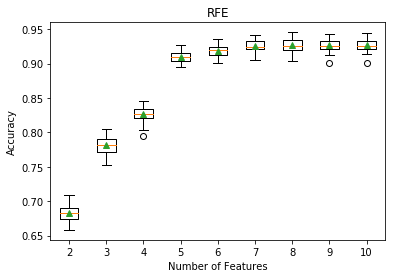

Maximum cross-validated accuracy with 10 features: 0.9264959052560978


In [44]:
get_features_rfe(lm)

In [47]:
scaler = StandardScaler()
model =LogisticRegression(multi_class='multinomial',max_iter= 1000)
rfe = RFE(estimator=model, n_features_to_select=7)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
scaled_pitch = scaler.fit_transform(pitch_data)
rfe.fit(scaled_pitch,train['type'])

for i in range(pitch_data.shape[1]):
    print('Attribute:', pitch_data.columns[i], 'selected %s, Rank: %.3f' % (rfe.support_[i], rfe.ranking_[i]))

Attribute: pitcherid selected True, Rank: 1.000
Attribute: yearid selected False, Rank: 3.000
Attribute: height selected True, Rank: 1.000
Attribute: initspeed selected True, Rank: 1.000
Attribute: breakx selected True, Rank: 1.000
Attribute: breakz selected True, Rank: 1.000
Attribute: initposx selected False, Rank: 2.000
Attribute: initposz selected True, Rank: 1.000
Attribute: extension selected False, Rank: 4.000
Attribute: spinrate selected True, Rank: 1.000


The features that were selected by RFE were `pitcherid`, `height`, `initspeed`, `breakx`, `breakz`,`initposz`, and `spinrate`

In [48]:
scaler = StandardScaler()
X_rfe = pd.DataFrame(pitch_data,columns=['pitcherid','height', 'initspeed', 'breakx','breakz','initposz','spinrate'])
X_scaled = scaler.fit_transform(X_rfe)

#### Logistic Regression Tuning

In [50]:
solvers = ['lbfgs', 'sag', 'saga','newton-cg'] 
s_scores = {}
for n in solvers:
    s_scores[n] = cross_validate(
        LogisticRegression(multi_class='multinomial',max_iter= 1000,solver = n),
        X_scaled,
        train['type'],
        cv= 10,
        scoring=('accuracy','f1_macro','f1_micro','f1_weighted')
        )
compare_scores(s_scores)

,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted
lbfgs,0.896188,0.0123064,0.925802,0.921432,0.925802,0.925668
sag,0.30003,0.0099467,0.925802,0.921432,0.925802,0.925668
saga,0.708644,0.00789945,0.925802,0.921432,0.925802,0.925668
newton-cg,0.513833,0.00859263,0.925802,0.921432,0.925802,0.925668


In [51]:
penalties = ['none', 'l2']
n_scores = {}
for n in penalties:
    n_scores[n] = cross_validate(
        LogisticRegression(multi_class='multinomial',max_iter= 1000,penalty = n),
        X_scaled,
        train['type'],
        cv= 10,
        scoring=('accuracy','f1_macro','f1_micro','f1_weighted')
        )
compare_scores(n_scores)

,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted
none,3.04422,0.0101624,0.926553,0.923917,0.926553,0.926499
l2,0.825414,0.010674,0.925802,0.921432,0.925802,0.925668


In [52]:
c_values = [100,10,1,.1,.01]
c_scores = {}
for n in c_values:
    c_scores[n] = cross_validate(
        LogisticRegression(multi_class='multinomial',max_iter= 1000,C = n),
        X_scaled,
        train['type'],
        cv= 10,
        scoring=('accuracy','f1_macro','f1_micro','f1_weighted')
        )
compare_scores(c_scores)

,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted
100.0,3.67965,0.0106535,0.926647,0.924067,0.926647,0.926592
10.0,1.75091,0.00839775,0.926929,0.924543,0.926929,0.926871
1.0,0.771772,0.00875843,0.925802,0.921432,0.925802,0.925668
0.1,0.339514,0.00998726,0.916785,0.901778,0.916785,0.916249
0.01,0.184131,0.00991549,0.878181,0.781043,0.878181,0.871427


In [99]:
scaler = StandardScaler()
X_rfe = pd.DataFrame(pitch_data,columns=['pitcherid','height', 'initspeed', 'breakx','breakz','initposz','spinrate'])
X_scaled = scaler.fit_transform(X_rfe)

In [105]:
c_values = [100,10,1,.1,.01]
model = LogisticRegression(multi_class='multinomial',max_iter=1000)
grid = dict(penalty=penalties,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_scaled, train['type'])

In [106]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.927116 using {'C': 100, 'penalty': 'l2'}
0.927022 (0.007404) with: {'C': 100, 'penalty': 'none'}
0.927116 (0.007414) with: {'C': 100, 'penalty': 'l2'}
0.927022 (0.007404) with: {'C': 10, 'penalty': 'none'}
0.926896 (0.007604) with: {'C': 10, 'penalty': 'l2'}
0.927022 (0.007404) with: {'C': 1, 'penalty': 'none'}
0.925550 (0.007792) with: {'C': 1, 'penalty': 'l2'}
0.927022 (0.007404) with: {'C': 0.1, 'penalty': 'none'}
0.917003 (0.007033) with: {'C': 0.1, 'penalty': 'l2'}
0.927022 (0.007404) with: {'C': 0.01, 'penalty': 'none'}
0.878463 (0.007593) with: {'C': 0.01, 'penalty': 'l2'}


#### Validation

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, train['type'], test_size= 0.2, random_state = 1)

In [111]:
logistic = LogisticRegression(multi_class='multinomial',max_iter=1000,C=100,penalty='l2')
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)

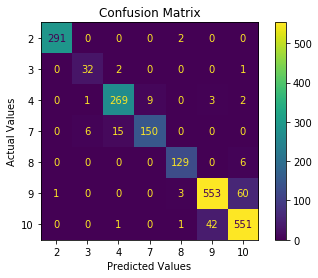

In [112]:
cm= metrics.plot_confusion_matrix(logistic, X_test,y_test)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [113]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           2       1.00      0.99      0.99       293
           3       0.82      0.91      0.86        35
           4       0.94      0.95      0.94       284
           7       0.94      0.88      0.91       171
           8       0.96      0.96      0.96       135
           9       0.92      0.90      0.91       617
          10       0.89      0.93      0.91       595

    accuracy                           0.93      2130
   macro avg       0.92      0.93      0.93      2130
weighted avg       0.93      0.93      0.93      2130



### KNN

In [24]:
neigh = KNeighborsClassifier()

Testing 2 features accuracy: 0.671 (0.014)
Testing 3 features accuracy: 0.798 (0.012)
Testing 4 features accuracy: 0.908 (0.007)
Testing 5 features accuracy: 0.924 (0.007)
Testing 6 features accuracy: 0.932 (0.007)
Testing 7 features accuracy: 0.932 (0.007)
Testing 8 features accuracy: 0.931 (0.008)
Testing 9 features accuracy: 0.932 (0.008)
Testing 10 features accuracy: 0.921 (0.009)


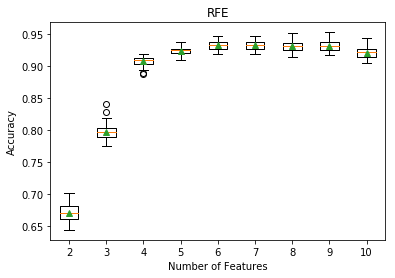

Maximum cross-validated accuracy with 6 features: 0.9323943838469414


In [60]:
get_features_kbest(neigh)

In [25]:
scaler = StandardScaler()
model = neigh
k_best = SelectKBest(f_classif,k=6)
pipeline = Pipeline(steps=[('s',k_best),('m',model)])
scaled_pitch = scaler.fit_transform(pitch_data)
k_best.fit(scaled_pitch,train['type'])

cols = k_best.get_support(indices=True)
for i in cols:
    print('Attribute:', pitch_data.columns[i])

X_knn = pd.DataFrame(pitch_data,columns=['pitcherid', 'initspeed', 'breakx','breakz','initposx','spinrate'])
X_knn_scaled = scaler.fit_transform(X_knn)

Attribute: pitcherid
Attribute: initspeed
Attribute: breakx
Attribute: breakz
Attribute: initposx
Attribute: spinrate


The features that were selected by SelectKBest were `pitcherid`, `initspeed`, `breakx`, `breakz`,`initposx`, and `spinrate`

#### KNN Hyperparameter Tuning

In [62]:
knn = cross_validate(
        neigh,
        X_knn_scaled,
        train['type'],
        cv= 10,
        scoring=('accuracy','f1_macro','f1_micro','f1_weighted')
        )

compare_scores({'KNN':knn})

,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted
KNN,0.0143159,0.0489796,0.933408,0.930834,0.933408,0.933187


In [63]:
neighbors = [1,2,3,5,10,15,20,25,50,100,500]
n_scores = {}
for n in neighbors:
    n_scores[n] = cross_validate(
        KNeighborsClassifier(n_neighbors=n),
        X_knn_scaled,
        train['type'],
        cv= 10,
        scoring=('accuracy','f1_macro','f1_micro','f1_weighted')
        )
compare_scores(n_scores)

,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted
1,0.0109198,0.0249912,0.910679,0.912706,0.910679,0.910465
2,0.0121892,0.0308609,0.904292,0.901856,0.904292,0.903845
3,0.00989943,0.0242789,0.928431,0.925076,0.928431,0.928225
5,0.00969656,0.0304554,0.933408,0.930834,0.933408,0.933187
10,0.00755582,0.0281225,0.934535,0.930376,0.934535,0.934253
15,0.00755992,0.0292755,0.934254,0.926912,0.934254,0.933867
20,0.00776103,0.031623,0.932469,0.923555,0.932469,0.932025
25,0.00857093,0.0362436,0.932375,0.924209,0.932375,0.931913
50,0.00810699,0.0466423,0.932469,0.92163,0.932469,0.931909
100,0.0101286,0.0837814,0.924954,0.908161,0.924954,0.924174


In [115]:
distances = ['euclidean','cosine','manhattan', 'minkowski','l1','l2']
d_scores = {}
for n in distances:
    d_scores[n] = cross_validate(
        KNeighborsClassifier(metric=n),
        X_knn_scaled,
        train['type'],
        cv= 10,
        scoring=('accuracy','f1_macro','f1_micro','f1_weighted')
        )
compare_scores(d_scores)

,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted
euclidean,0.0145284,0.0408689,0.933408,0.930834,0.933408,0.933187
cosine,0.00275424,0.249444,0.931905,0.92843,0.931905,0.931655
manhattan,0.00964038,0.039918,0.932094,0.930027,0.932094,0.931863
minkowski,0.0133479,0.0347909,0.933408,0.930834,0.933408,0.933187
l1,0.0104465,0.0395841,0.932094,0.930027,0.932094,0.931863
l2,0.00965731,0.0291448,0.933408,0.930834,0.933408,0.933187


In [114]:
weights = ['uniform','distance']
w_scores = {}
for n in weights:
    w_scores[n] = cross_validate(
        KNeighborsClassifier(weights = n),
        X_knn_scaled,
        train['type'],
        cv= 10,
        scoring=('accuracy','f1_macro','f1_micro','f1_weighted')
        )
compare_scores(w_scores)

,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted
uniform,0.0110787,0.0363686,0.933408,0.930834,0.933408,0.933187
distance,0.0135234,0.0382564,0.932845,0.930194,0.932845,0.932642


In [116]:
model = KNeighborsClassifier()
grid = dict(n_neighbors = neighbors,metric=distances,weights=weights)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_knn_scaled, train['type'])

In [118]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.935913 using {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}


#### Validation

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_knn_scaled, train['type'], test_size= 0.3, random_state = 1)

In [27]:
knn = KNeighborsClassifier(n_neighbors = 15,metric='manhattan')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

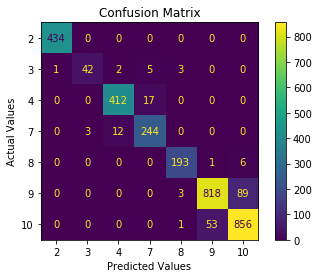

In [28]:
cm= metrics.plot_confusion_matrix(knn, X_test,y_test)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [29]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00       434
           3       0.93      0.79      0.86        53
           4       0.97      0.96      0.96       429
           7       0.92      0.94      0.93       259
           8       0.96      0.96      0.96       200
           9       0.94      0.90      0.92       910
          10       0.90      0.94      0.92       910

    accuracy                           0.94      3195
   macro avg       0.95      0.93      0.94      3195
weighted avg       0.94      0.94      0.94      3195



### Single Decision Tree

In [351]:
tree = DecisionTreeClassifier()

Testing 2 features accuracy: 0.746 (0.021)
Testing 3 features accuracy: 0.836 (0.010)
Testing 4 features accuracy: 0.868 (0.009)
Testing 5 features accuracy: 0.885 (0.008)
Testing 6 features accuracy: 0.896 (0.009)
Testing 7 features accuracy: 0.893 (0.008)
Testing 8 features accuracy: 0.895 (0.009)
Testing 9 features accuracy: 0.894 (0.009)
Testing 10 features accuracy: 0.894 (0.008)


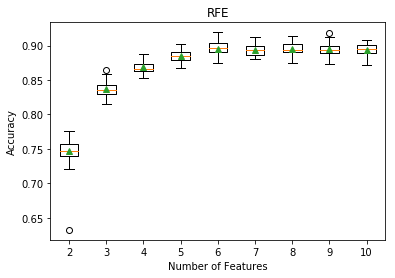

Maximum cross-validated accuracy with 6 features: 0.8955948851000742


In [352]:
get_features_rfe(tree)

In [353]:
scaler = StandardScaler()
model = DecisionTreeClassifier()
rfe = RFE(estimator=model, n_features_to_select=6)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
scaled_pitch = scaler.fit_transform(pitch_data)
rfe.fit(scaled_pitch,train['type'])

for i in range(pitch_data.shape[1]):
    print('Attribute:', pitch_data.columns[i], 'selected %s, Rank: %.3f' % (rfe.support_[i], rfe.ranking_[i]))

Attribute: pitcherid selected True, Rank: 1.000
Attribute: yearid selected False, Rank: 5.000
Attribute: height selected False, Rank: 4.000
Attribute: initspeed selected True, Rank: 1.000
Attribute: breakx selected True, Rank: 1.000
Attribute: breakz selected True, Rank: 1.000
Attribute: initposx selected True, Rank: 1.000
Attribute: initposz selected False, Rank: 2.000
Attribute: extension selected False, Rank: 3.000
Attribute: spinrate selected True, Rank: 1.000


The features that were selected by RFE were `pitcherid`, `initspeed`, `breakx`, `breakz`,`initposx`, and `spinrate`

In [122]:
X_tree = pd.DataFrame(pitch_data,columns=['pitcherid', 'initspeed', 'breakx','breakz','initposx','spinrate'])
X_tree_scaled = scaler.fit_transform(X_tree)

#### Decision Tree Tuning

In [123]:
features = np.arange(1,7)
f_scores = {}
for n in features:
    f_scores[n] = cross_validate(
        DecisionTreeClassifier(max_features=n),
        X_tree_scaled,
        train['type'],
        cv= 10,
        scoring=('accuracy','f1_macro','f1_micro','f1_weighted')
        )
compare_scores(f_scores)

,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted
1,0.0198092,0.0104658,0.87649,0.86583,0.87649,0.876361
2,0.0253856,0.00827067,0.887577,0.87912,0.887577,0.887634
3,0.0397399,0.0115253,0.895933,0.891531,0.895933,0.895765
4,0.0518419,0.0108967,0.895558,0.890804,0.895558,0.895414
5,0.0734208,0.0105198,0.899407,0.896054,0.899407,0.899364
6,0.0706215,0.0101503,0.894711,0.888211,0.894711,0.894767


In [124]:
criteria = ['gini', 'entropy']
c_scores = {}
for n in criteria:
    c_scores[n] = cross_validate(
        DecisionTreeClassifier(criterion=n),
        X_tree_scaled,
        train['type'],
        cv= 10,
        scoring=('accuracy','f1_macro','f1_micro','f1_weighted')
        )
compare_scores(c_scores)

,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted
gini,0.0732749,0.0108867,0.895087,0.887757,0.895087,0.894994
entropy,0.128231,0.0141028,0.897437,0.897305,0.897437,0.897345


In [125]:
splitters = ['best','random']
s_scores = {}
for n in splitters:
    s_scores[n] = cross_validate(
        DecisionTreeClassifier(splitter=n),
        X_tree_scaled,
        train['type'],
        cv= 10,
        scoring=('accuracy','f1_macro','f1_micro','f1_weighted')
        )
compare_scores(s_scores)

,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted
best,0.0678787,0.0078788,0.896027,0.890845,0.896027,0.896013
random,0.0083988,0.00718935,0.89678,0.886112,0.89678,0.896763


In [126]:
model = DecisionTreeClassifier()
grid = dict(max_features = features,criterion=criteria,splitter=splitters)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_scaled, train['type'])

In [128]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.904354 using {'criterion': 'entropy', 'max_features': 6, 'splitter': 'best'}


### Validation

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_tree_scaled, train['type'], test_size= 0.2, random_state = 1)

In [130]:
d_tree = DecisionTreeClassifier(max_features=6,criterion='entropy',splitter='best')
d_tree.fit(X_train, y_train)
y_pred = d_tree.predict(X_test)

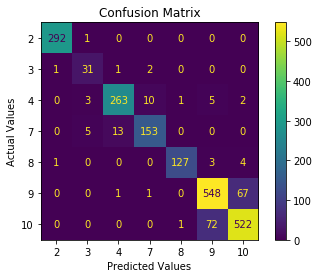

In [131]:
cm= metrics.plot_confusion_matrix(d_tree, X_test,y_test)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [132]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           2       0.99      1.00      0.99       293
           3       0.78      0.89      0.83        35
           4       0.95      0.93      0.94       284
           7       0.92      0.89      0.91       171
           8       0.98      0.94      0.96       135
           9       0.87      0.89      0.88       617
          10       0.88      0.88      0.88       595

    accuracy                           0.91      2130
   macro avg       0.91      0.92      0.91      2130
weighted avg       0.91      0.91      0.91      2130



### Random Forest

In [30]:
forest = RandomForestClassifier()

Testing 2 features accuracy: 0.681 (0.013)
Testing 3 features accuracy: 0.803 (0.013)
Testing 4 features accuracy: 0.908 (0.008)
Testing 5 features accuracy: 0.925 (0.009)
Testing 6 features accuracy: 0.935 (0.008)
Testing 7 features accuracy: 0.936 (0.008)
Testing 8 features accuracy: 0.938 (0.008)
Testing 9 features accuracy: 0.937 (0.007)
Testing 10 features accuracy: 0.938 (0.008)


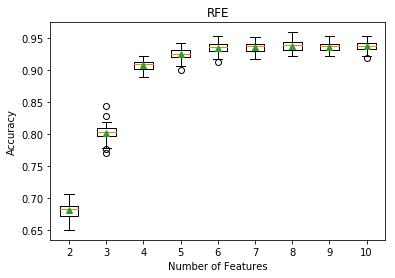

Maximum cross-validated accuracy with 8 features: 0.9384992410603975


In [369]:
get_features_kbest(forest)

In [31]:
scaler = StandardScaler()
k_best = SelectKBest(f_classif,k=8)
pipeline = Pipeline(steps=[('s',k_best),('m',forest)])
scaled_pitch = scaler.fit_transform(pitch_data)
k_best.fit(scaled_pitch,train['type'])

cols = k_best.get_support(indices=True)
for i in cols:
    print('Attribute:', pitch_data.columns[i])

Attribute: pitcherid
Attribute: height
Attribute: initspeed
Attribute: breakx
Attribute: breakz
Attribute: initposx
Attribute: initposz
Attribute: spinrate


The features that were selected by SelectKBest were `pitcherid`,`height`, `initspeed`, `breakx`, `breakz`, `initposx`,`initposz`, and `spinrate`

In [32]:
X_forest = pd.DataFrame(pitch_data,columns=['pitcherid','height', 'initspeed', 'breakx','breakz','initposx','initposz','spinrate'])
X_forest_scaled = scaler.fit_transform(X_forest)

#### Random Forest Tuning

In [414]:
features = np.arange(1,9)
f_scores = {}
for n in features:
    f_scores[n] = cross_validate(
        RandomForestClassifier(max_features=n),
        X_forest_scaled,
        train['type'],
        cv= 10,
        scoring=('accuracy','f1_macro','f1_micro','f1_weighted')
        )
compare_scores(f_scores)

,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted
1,1.15569,0.0483065,0.937259,0.935962,0.937259,0.937016
2,1.65163,0.0507456,0.937166,0.938818,0.937166,0.936978
3,2.04617,0.0425189,0.936884,0.937297,0.936884,0.936723
4,2.87885,0.0439143,0.935663,0.935882,0.935663,0.935526
5,3.11698,0.0406836,0.935287,0.935287,0.935287,0.935115
6,3.69826,0.038798,0.934347,0.93418,0.934347,0.934236
7,4.22964,0.0406429,0.932657,0.931494,0.932657,0.932548
8,4.88027,0.0368465,0.93059,0.929976,0.93059,0.930479


In [415]:
features = ['log2','sqrt']
f_scores = {}
for n in features:
    f_scores[n] = cross_validate(
        RandomForestClassifier(max_features=n),
        X_forest_scaled,
        train['type'],
        cv= 10,
        scoring=('accuracy','f1_macro','f1_micro','f1_weighted')
        )
compare_scores(f_scores)

,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted
log2,2.1633,0.045995,0.935663,0.936168,0.935663,0.9355
sqrt,2.05643,0.0418918,0.937635,0.937594,0.937635,0.937465


In [134]:
estimators = [1,10,50,100,250,500,1000]
e_scores = {}
for n in estimators:
    e_scores[n] = cross_validate(
        RandomForestClassifier(n_estimators=n),
        X_forest_scaled,
        train['type'],
        cv= 10,
        scoring=('accuracy','f1_macro','f1_micro','f1_weighted')
        )
compare_scores(e_scores)

,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted
1,0.0406304,0.0183458,0.882316,0.872528,0.882316,0.882219
10,0.234308,0.0153558,0.931531,0.93061,0.931531,0.931331
50,1.34221,0.0384569,0.936132,0.9374,0.936132,0.935952
100,2.62784,0.0739723,0.936884,0.936027,0.936884,0.936683
250,7.86059,0.178157,0.936414,0.936279,0.936414,0.936228
500,18.3826,0.476871,0.938574,0.939733,0.938574,0.938437
1000,25.9737,0.53077,0.937541,0.937806,0.937541,0.937361


In [135]:
model = RandomForestClassifier()
grid = dict(max_features = [1,2,3,4,5,6,7,8,'log2','sqrt'],n_estimators=estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_forest_scaled, train['type'])

In [136]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.938573 using {'max_features': 1, 'n_estimators': 1000}


#### Validation

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_forest_scaled, train['type'], test_size= 0.2, random_state = 1)

In [34]:
d_forest = RandomForestClassifier(max_features=1,n_estimators=1000)
d_forest.fit(X_train, y_train)
y_pred = d_forest.predict(X_test)

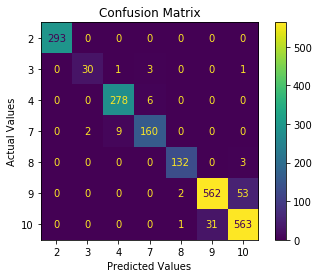

In [35]:
cm= metrics.plot_confusion_matrix(d_forest, X_test,y_test)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [36]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00       293
           3       0.94      0.86      0.90        35
           4       0.97      0.98      0.97       284
           7       0.95      0.94      0.94       171
           8       0.98      0.98      0.98       135
           9       0.95      0.91      0.93       617
          10       0.91      0.95      0.93       595

    accuracy                           0.95      2130
   macro avg       0.95      0.94      0.95      2130
weighted avg       0.95      0.95      0.95      2130



### Gradient Boosted Trees

In [37]:
boost = xgb.XGBClassifier(objective = 'multi:softmax')

Testing 2 features accuracy: 0.710 (0.013)
Testing 3 features accuracy: 0.810 (0.012)
Testing 4 features accuracy: 0.909 (0.008)
Testing 5 features accuracy: 0.924 (0.008)
Testing 6 features accuracy: 0.936 (0.008)
Testing 7 features accuracy: 0.936 (0.008)
Testing 8 features accuracy: 0.937 (0.008)
Testing 9 features accuracy: 0.937 (0.008)
Testing 10 features accuracy: 0.937 (0.008)


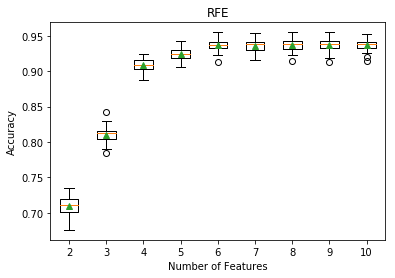

Maximum cross-validated accuracy with 8 features: 0.93733463941544


In [141]:
get_features_kbest(boost)

In [144]:
scaler = StandardScaler()
k_best = SelectKBest(f_classif,k=8)
pipeline = Pipeline(steps=[('s',k_best),('m',boost)])
scaled_pitch = scaler.fit_transform(pitch_data)
k_best.fit(scaled_pitch,train['type'])

cols = k_best.get_support(indices=True)
for i in cols:
    print('Attribute:', pitch_data.columns[i])

Attribute: pitcherid
Attribute: height
Attribute: initspeed
Attribute: breakx
Attribute: breakz
Attribute: initposx
Attribute: initposz
Attribute: spinrate


The features that were selected by SelectKBest were `pitcherid`,`height`, `initspeed`, `breakx`, `breakz`,`initposx`,`initposz`, and `spinrate`

In [38]:
X_boost = pd.DataFrame(pitch_data,columns=['pitcherid','height', 'initspeed', 'breakx','breakz','initposx','initposz','spinrate'])
X_boost_scaled = scaler.fit_transform(X_boost)

#### XGBoost Tuning

In [146]:
estimators = [100,250,500,750,1000]
e_scores = {}
for n in estimators:
    e_scores[n] = cross_validate(
        xgb.XGBClassifier(objective = 'multi:softmax',n_estimators = n),
        X_boost_scaled,
        train['type'],
        cv= 10,
        scoring=('accuracy','f1_macro','f1_micro','f1_weighted')
        )
compare_scores(e_scores)

,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted
100,5.74394,0.0364187,0.937447,0.937276,0.937447,0.937299
250,14.3841,0.1137,0.938575,0.937494,0.938575,0.938424
500,30.1204,0.259176,0.937166,0.936713,0.937166,0.937053
750,40.9323,0.42331,0.936321,0.935963,0.936321,0.936212
1000,51.3734,0.637866,0.936039,0.935654,0.936039,0.935923


In [147]:
rates = [.001,.01,.1]
l_scores = {}
for n in rates:
    l_scores[n] = cross_validate(
        xgb.XGBClassifier(objective = 'multi:softmax',learning_rate = n),
        X_boost_scaled,
        train['type'],
        cv= 10,
        scoring=('accuracy','f1_macro','f1_micro','f1_weighted')
        )
compare_scores(l_scores)

,fit_time,score_time,test_accuracy,test_f1_macro,test_f1_micro,test_f1_weighted
0.001,5.9328,0.0338668,0.886447,0.83984,0.886447,0.883723
0.01,6.56696,0.0418827,0.893679,0.842255,0.893679,0.890788
0.1,5.64511,0.0386474,0.937447,0.937276,0.937447,0.937299


In [148]:
model = xgb.XGBClassifier(objective = 'multi:softmax')
grid = dict(subsample = [.5,.75,1.0],max_depth = [3,5,7,9])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_boost_scaled, train['type'])

In [149]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.939513 using {'max_depth': 5, 'subsample': 0.5}


#### Validation

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_boost_scaled, train['type'], test_size= 0.2, random_state = 1)
d_boost = xgb.XGBClassifier(objective = 'multi:softmax',max_depth = 5, subsample = .5, learning_rate = .1, estimators= 250)
d_boost.fit(X_train,y_train)
y_pred = d_boost.predict(X_test)

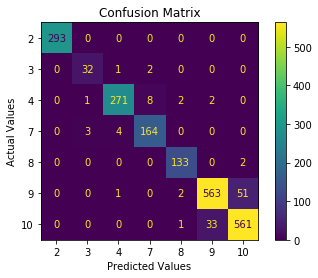

In [40]:
cm= metrics.plot_confusion_matrix(d_boost, X_test,y_test)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [41]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00       293
           3       0.89      0.91      0.90        35
           4       0.98      0.95      0.97       284
           7       0.94      0.96      0.95       171
           8       0.96      0.99      0.97       135
           9       0.94      0.91      0.93       617
          10       0.91      0.94      0.93       595

    accuracy                           0.95      2130
   macro avg       0.95      0.95      0.95      2130
weighted avg       0.95      0.95      0.95      2130



### Multi-Layer Perceptron

In [11]:
perceptron = MLPClassifier(random_state=1, max_iter=200)

Testing 2 features accuracy: 0.715 (0.013)
Testing 3 features accuracy: 0.819 (0.011)
Testing 4 features accuracy: 0.915 (0.007)
Testing 5 features accuracy: 0.931 (0.008)
Testing 6 features accuracy: 0.941 (0.007)
Testing 7 features accuracy: 0.941 (0.008)
Testing 8 features accuracy: 0.944 (0.008)
Testing 9 features accuracy: 0.943 (0.008)
Testing 10 features accuracy: 0.942 (0.008)


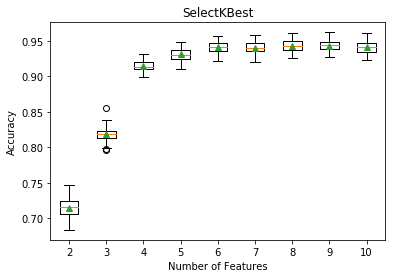

Maximum cross-validated accuracy with 8 features: 0.9435334992410604


In [166]:
get_features_kbest(perceptron)

In [12]:
scaler = StandardScaler()
k_best = SelectKBest(f_classif,k=8)
pipeline = Pipeline(steps=[('s',k_best),('m',perceptron)])
scaled_pitch = scaler.fit_transform(pitch_data)
k_best.fit(scaled_pitch,train['type'])

cols = k_best.get_support(indices=True)
for i in cols:
    print('Attribute:', pitch_data.columns[i])

Attribute: pitcherid
Attribute: height
Attribute: initspeed
Attribute: breakx
Attribute: breakz
Attribute: initposx
Attribute: initposz
Attribute: spinrate


The features that were selected by SelectKBest were `pitcherid`,`height`, `initspeed`, `breakx`, `breakz`, `initposx`,`initposz`, and `spinrate`

In [13]:
X_perceptron = pd.DataFrame(pitch_data,columns=['pitcherid','height', 'initspeed', 'breakx','breakz','initposx','initposz','spinrate'])
X_perceptron_scaled = scaler.fit_transform(X_perceptron)

#### MLP Tuning

In [14]:
grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [15]:
model = MLPClassifier(random_state=1, max_iter=200)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_perceptron_scaled, train['type'])

In [16]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.943552 using {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


#### Validation

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_perceptron_scaled, train['type'], test_size= 0.2, random_state = 1)
d_perceptron = MLPClassifier(random_state=1, max_iter=500,activation = 'relu',alpha = .0001,hidden_layer_sizes = (100,),learning_rate = 'constant',solver = 'adam')
d_perceptron.fit(X_train,y_train)
y_pred = d_perceptron.predict(X_test)

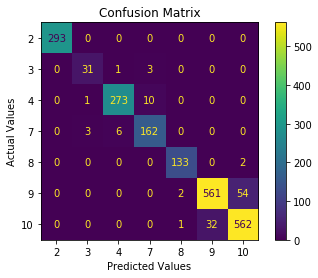

In [19]:
cm= metrics.plot_confusion_matrix(d_perceptron, X_test,y_test)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [20]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00       293
           3       0.89      0.89      0.89        35
           4       0.97      0.96      0.97       284
           7       0.93      0.95      0.94       171
           8       0.98      0.99      0.98       135
           9       0.95      0.91      0.93       617
          10       0.91      0.94      0.93       595

    accuracy                           0.95      2130
   macro avg       0.95      0.95      0.95      2130
weighted avg       0.95      0.95      0.95      2130



### Ensembles

In [51]:
voting_clf = VotingClassifier(
 estimators=[ ('decision', d_forest),('boost',d_boost),('perceptron',d_perceptron)],
 voting='hard')

In [52]:
X_ensemble = pd.DataFrame(pitch_data,columns=['pitcherid','height', 'initspeed', 'breakx','breakz','initposx','initposz','extension','spinrate'])
X_ensemble_scaled = scaler.fit_transform(X_ensemble)
X_train, X_test, y_train, y_test = train_test_split(X_ensemble_scaled, train['type'], test_size= 0.2, random_state = 1)

In [53]:
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

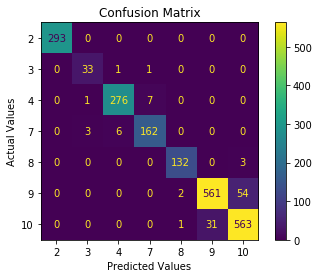

In [54]:
cm= metrics.plot_confusion_matrix(voting_clf, X_test,y_test)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [55]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00       293
           3       0.89      0.94      0.92        35
           4       0.98      0.97      0.97       284
           7       0.95      0.95      0.95       171
           8       0.98      0.98      0.98       135
           9       0.95      0.91      0.93       617
          10       0.91      0.95      0.93       595

    accuracy                           0.95      2130
   macro avg       0.95      0.96      0.95      2130
weighted avg       0.95      0.95      0.95      2130



### Why are pitch type 9 and 10 mistaken for one another across all the models?

In [49]:
train.groupby('type').mean()

,pitchid,height,initspeed,breakx,breakz,initposx,initposz,extension,spinrate
type,,,,,,,,,
2,5279.143628,75.417397,76.985002,4.891531,-6.840646,-1.772112,5.951901,6.192740,2512.840170
3,5589.507317,72.048780,82.459450,1.058762,-0.033204,-1.383025,5.754445,6.207139,1867.163590
4,5404.150376,74.312782,83.821216,-5.606788,3.452922,-1.744082,5.894749,6.195986,1364.294229
7,5549.552719,72.000000,84.628220,-2.907276,2.479132,-1.022949,5.992991,6.205710,988.921064
8,5006.261128,72.000000,88.903118,1.232930,4.711424,-1.814539,5.813319,6.205121,2346.130695
9,5391.456640,74.241192,91.150766,-7.125659,6.906634,-1.827878,5.856179,6.204459,2065.166776
10,5232.863314,74.121857,92.140954,-3.185415,9.446620,-1.626804,5.942039,6.194828,2131.525759


It is important to note that pitches **9** and **10** were the most frequent in the dataset , and from the aggregate pitch data they have the greatest initial velocity and both go in the same direction relative to the plate, with pitch 9 breaking more inside for example. The two pitches also have the greatest magnitude of break compared to the others as well as similar spin rates. 

## Model Summaries and Conclusion

| Model | Validation Accuracy (Weighted) | Approx. Tuning Execution Time | Number of Features
| :- | :-: | :-: | :-:
| Multinomial Logistic Regression | .93 | 1 minute | 7
| KNN | .94 | 20 minutes | 6
| Single Decision Tree | .91 | 20 minutes | 6
| Random Forest | .95 | 30 minutes | 8
| XGBoost | .95 | 40 minutes | 8
| Multi-Layer Perceptron | .95 | 3 hours | 8

We saw high accuracy scores on all of the validation sets for each model, while the best performers were Random Forest, XGBoost, and MLP-Classifier. The ensemble model of the highest performing models also didn't exceed any of the scores. I chose to use the ensemble model for the test set, but you could generally expect similar performance of each of the models individually as they all also had identical feature sets. As for the feature sets used in different models, they all fell between 6-8 of total features with `pitcherid`, `initspeed`, `breakx`, `breakz`, `initposx`, `initposz`, and `spinrate` being in **all** feature sets. There were also minimal increases or slight decreases in accuracy in adding more features beyond 6-8 for each model.

## Test Set

In [56]:
voting_clf = VotingClassifier(
 estimators=[ ('decision', d_forest),('boost',d_boost),('perceptron',d_perceptron)],
 voting='hard')

In [61]:
X_ensemble = pd.DataFrame(train,columns=['pitcherid','height', 'initspeed', 'breakx','breakz','initposx','initposz','extension','spinrate'])
X_ensemble_scaled = scaler.fit_transform(X_ensemble)

In [62]:
voting_clf.fit(X_ensemble_scaled, train['type'])

VotingClassifier(estimators=[('decision',
                              RandomForestClassifier(max_features=1,
                                                     n_estimators=1000)),
                             ('boost',
                              XGBClassifier(estimators=250, max_depth=5,
                                            objective='multi:softprob',
                                            subsample=0.5)),
                             ('perceptron',
                              MLPClassifier(max_iter=500, random_state=1))])

In [76]:
test = test.astype({'pitcherid':'category','yearid':'category'})

In [77]:
test_pitch_data = pd.DataFrame(test,columns=['pitcherid','height', 'initspeed', 'breakx','breakz','initposx','initposz','extension','spinrate'])

In [96]:
scaler = StandardScaler()
test_scaled = scaler.fit_transform(test_pitch_data)
y_pred = voting_clf.predict(test_scaled)

In [97]:
final_submission = pd.DataFrame(test['pitchid'])
final_submission['predicted type'] = y_pred

In [98]:
final_submission

,pitchid,predicted type
0,10648,10
1,10649,9
2,10650,9
3,10651,10
4,10652,10
...,...,...
12349,22997,2
12350,22998,4
12351,22999,10
12352,23000,7


In [95]:
final_submission.to_csv('pitchid_submission',index=False)

## Citations

- https://machinelearningmastery.com/
- https://scikit-learn.org/stable/modules/classes.html
- https://pandas.pydata.org/docs/index.html
- https://matplotlib.org/stable/index.html
- https://www.statsmodels.org/stable/index.html